In [200]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from xgboost import XGBRegressor


In [201]:
data_path = "./data/lot41_statistical.csv"
df = pd.read_csv(data_path)
df.head(5)

,name,price,brand,item_condition,shipping,located_in,return_policy,category,money_back,seller_item_sold,trending,price_boxcox,price_log
0,Mens Jogging Bottoms Elasticated Trouser Jogge...,14.48,Crazy Girl Ltd,New with tags,(approx C $10.20),United Kingdom,14 days return . Buyer pays for return shippi...,"Clothing, Shoes & Accessories/Men/Men's Clothi...",Yes,203K,Yes/3,3.488990,2.739549
1,Men's 100% Cotton Big Polka Dot Design Spread...,29.19,George/Fortino Landi,New with tags,(approx C $7.30),United States,30 days return . Buyer pays for return shippi...,"Clothing, Shoes & Accessories/Men/Men's Clothi...",Yes,49K,Yes/56,4.739931,3.407511
2,G-Unit Style heavy weigh Tank Top Square Cut ...,15.89,Basix,New with tags,(approx C $25.88),United States,30 days return . Buyer pays for return shippi...,"Clothing, Shoes & Accessories/Men/Men's Clothi...",Yes,207K,Yes/5,3.645312,2.826722
3,Men's Fashion Oxford Faux Leather Dress Shoes...,33.23,Milano Moda & Alberto Fellini,New with box,(approx C $56.04),United States,30 days return . Buyer pays for return shippi...,"Clothing, Shoes & Accessories/Men/Men's Shoes/...",Yes,49K,Yes/715,4.990177,3.533102
4,Women's Cute Caged Peep Toe Low High Platform ...,15.81,Top Moda,New without box,(approx C $30.72),United States,30 days return . Buyer pays for return shippi...,"Clothing, Shoes & Accessories/Women/Women's Sh...",Yes,326K,No,3.636750,2.821974


In [202]:
df.shape

(17893, 13)

In [203]:
tfid = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfid.fit_transform(df['name'])
k_means = KMeans(n_clusters=50, random_state=0)
k_means.fit(tfidf_matrix)
df['name'] = k_means.labels_
df.head()

/Users/jaxxsulav/Projects/Loyalist/Sem2/Step/PriceProphet/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,name,price,brand,item_condition,shipping,located_in,return_policy,category,money_back,seller_item_sold,trending,price_boxcox,price_log
0,43,14.48,Crazy Girl Ltd,New with tags,(approx C $10.20),United Kingdom,14 days return . Buyer pays for return shippi...,"Clothing, Shoes & Accessories/Men/Men's Clothi...",Yes,203K,Yes/3,3.488990,2.739549
1,2,29.19,George/Fortino Landi,New with tags,(approx C $7.30),United States,30 days return . Buyer pays for return shippi...,"Clothing, Shoes & Accessories/Men/Men's Clothi...",Yes,49K,Yes/56,4.739931,3.407511
2,3,15.89,Basix,New with tags,(approx C $25.88),United States,30 days return . Buyer pays for return shippi...,"Clothing, Shoes & Accessories/Men/Men's Clothi...",Yes,207K,Yes/5,3.645312,2.826722
3,1,33.23,Milano Moda & Alberto Fellini,New with box,(approx C $56.04),United States,30 days return . Buyer pays for return shippi...,"Clothing, Shoes & Accessories/Men/Men's Shoes/...",Yes,49K,Yes/715,4.990177,3.533102
4,49,15.81,Top Moda,New without box,(approx C $30.72),United States,30 days return . Buyer pays for return shippi...,"Clothing, Shoes & Accessories/Women/Women's Sh...",Yes,326K,No,3.636750,2.821974


##### Binarizing return_policy, money_back, trending

In [204]:
df['return_policy'] = df['return_policy'].apply(lambda x: 0 if 'no' in x.lower() else 1)
df['money_back'] = df['money_back'].apply(lambda x: 1 if 'yes' in x.lower() else 0)
df['trending'] = df['trending'].apply(lambda x: 1 if 'yes' in x.lower() else 0)
df.head()

,name,price,brand,item_condition,shipping,located_in,return_policy,category,money_back,seller_item_sold,trending,price_boxcox,price_log
0,43,14.48,Crazy Girl Ltd,New with tags,(approx C $10.20),United Kingdom,1,"Clothing, Shoes & Accessories/Men/Men's Clothi...",1,203K,1,3.488990,2.739549
1,2,29.19,George/Fortino Landi,New with tags,(approx C $7.30),United States,1,"Clothing, Shoes & Accessories/Men/Men's Clothi...",1,49K,1,4.739931,3.407511
2,3,15.89,Basix,New with tags,(approx C $25.88),United States,1,"Clothing, Shoes & Accessories/Men/Men's Clothi...",1,207K,1,3.645312,2.826722
3,1,33.23,Milano Moda & Alberto Fellini,New with box,(approx C $56.04),United States,1,"Clothing, Shoes & Accessories/Men/Men's Shoes/...",1,49K,1,4.990177,3.533102
4,49,15.81,Top Moda,New without box,(approx C $30.72),United States,1,"Clothing, Shoes & Accessories/Women/Women's Sh...",1,326K,0,3.636750,2.821974


#### Dealing with Category

In [205]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

df['category'] = enc.fit_transform(df[['category']]).astype(int)
kv_pair_ic = {category: i for i, category in enumerate(enc.categories_[0])}
print(kv_pair_ic)
print(len(enc.categories_[0]))
df.head()

{"Business & Industrial/Facility Maintenance & Safety/Personal Protective Equipment (PPE)/Protective Jackets/Clothing, Shoes & Accessories/Men/Men's Clothing/Men/Men's Clothing/Activewear/Hoodies & Sweatshirts": 0, "Business & Industrial/Facility Maintenance & Safety/Personal Protective Equipment (PPE)/Protective Jackets/Clothing, Shoes & Accessories/Men/Men's Clothing/Men/Men's Clothing/Shirts/Casual Button-Down Shirts": 1, "Business & Industrial/Facility Maintenance & Safety/Personal Protective Equipment (PPE)/Protective Pants/Clothing, Shoes & Accessories/Men/Men's Clothing/Pants": 2, "Business & Industrial/Facility Maintenance & Safety/Personal Protective Equipment (PPE)/Protective Suits & Coveralls/Clothing, Shoes & Accessories/Men/Men's Clothing/Pants": 3, 'Business & Industrial/Facility Maintenance & Safety/Personal Protective Equipment (PPE)/Work Boots & Shoes': 4, "Business & Industrial/Facility Maintenance & Safety/Personal Protective Equipment (PPE)/Work Boots & Shoes/Clothi

,name,price,brand,item_condition,shipping,located_in,return_policy,category,money_back,seller_item_sold,trending,price_boxcox,price_log
0,43,14.48,Crazy Girl Ltd,New with tags,(approx C $10.20),United Kingdom,1,23,1,203K,1,3.488990,2.739549
1,2,29.19,George/Fortino Landi,New with tags,(approx C $7.30),United States,1,63,1,49K,1,4.739931,3.407511
2,3,15.89,Basix,New with tags,(approx C $25.88),United States,1,74,1,207K,1,3.645312,2.826722
3,1,33.23,Milano Moda & Alberto Fellini,New with box,(approx C $56.04),United States,1,167,1,49K,1,4.990177,3.533102
4,49,15.81,Top Moda,New without box,(approx C $30.72),United States,1,339,1,326K,0,3.636750,2.821974


#### Binarizing the shipping values

In [206]:
df.loc[~df['shipping'].astype(str).str.contains('\$'), 'shipping'] = 0
df.loc[df['shipping'].astype(str).str.contains('\$'), 'shipping'] = 1
df['shipping'] = df['shipping'].astype(float)
df.head()

,name,price,brand,item_condition,shipping,located_in,return_policy,category,money_back,seller_item_sold,trending,price_boxcox,price_log
0,43,14.48,Crazy Girl Ltd,New with tags,1.0,United Kingdom,1,23,1,203K,1,3.488990,2.739549
1,2,29.19,George/Fortino Landi,New with tags,1.0,United States,1,63,1,49K,1,4.739931,3.407511
2,3,15.89,Basix,New with tags,1.0,United States,1,74,1,207K,1,3.645312,2.826722
3,1,33.23,Milano Moda & Alberto Fellini,New with box,1.0,United States,1,167,1,49K,1,4.990177,3.533102
4,49,15.81,Top Moda,New without box,1.0,United States,1,339,1,326K,0,3.636750,2.821974


### Dealing with seller_item_sold

In [207]:
# For "seller_positive_feedback"
def to_numbers(short):
    if 'K' in short:
        return float(short.replace('K', '')) * 1000
    elif 'M' in short:
        return float(short.replace('M', '')) * 1000000
    else:
        return float(short)

df["seller_item_sold"] = df["seller_item_sold"].apply(to_numbers)

In [208]:
# from sklearn.model_selection import train_test_split

# train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

### Target Encoder for item_condition

In [209]:
encoder = TargetEncoder()
encoder.fit(df['item_condition'], df['price_log'])

df['item_condition'] = encoder.transform(df['item_condition'])

In [210]:
encoder.fit(df['located_in'], df['price_log'])

df['located_in'] = encoder.transform(df['located_in'])
df.head()

,name,price,brand,item_condition,shipping,located_in,return_policy,category,money_back,seller_item_sold,trending,price_boxcox,price_log
0,43,14.48,Crazy Girl Ltd,3.346548,1.0,3.272318,1,23,1,203000.0,1,3.488990,2.739549
1,2,29.19,George/Fortino Landi,3.346548,1.0,3.893614,1,63,1,49000.0,1,4.739931,3.407511
2,3,15.89,Basix,3.346548,1.0,3.893614,1,74,1,207000.0,1,3.645312,2.826722
3,1,33.23,Milano Moda & Alberto Fellini,4.136576,1.0,3.893614,1,167,1,49000.0,1,4.990177,3.533102
4,49,15.81,Top Moda,3.890525,1.0,3.893614,1,339,1,326000.0,0,3.636750,2.821974


17893

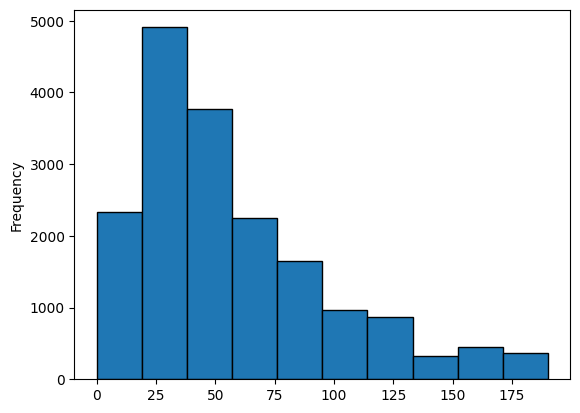

In [211]:

df['price'].plot(kind='hist', edgecolor='black')
len(df)

In [212]:
encoder.fit(df['brand'], df['price_log'])

df['brand'] = encoder.transform(df['brand'])
df.head()

,name,price,brand,item_condition,shipping,located_in,return_policy,category,money_back,seller_item_sold,trending,price_boxcox,price_log
0,43,14.48,3.360062,3.346548,1.0,3.272318,1,23,1,203000.0,1,3.488990,2.739549
1,2,29.19,3.770229,3.346548,1.0,3.893614,1,63,1,49000.0,1,4.739931,3.407511
2,3,15.89,3.694664,3.346548,1.0,3.893614,1,74,1,207000.0,1,3.645312,2.826722
3,1,33.23,3.786570,4.136576,1.0,3.893614,1,167,1,49000.0,1,4.990177,3.533102
4,49,15.81,3.750213,3.890525,1.0,3.893614,1,339,1,326000.0,0,3.636750,2.821974


In [213]:
df.dtypes

name                  int32
price               float64
brand               float64
item_condition      float64
shipping            float64
located_in          float64
return_policy         int64
category              int64
money_back            int64
seller_item_sold    float64
trending              int64
price_boxcox        float64
price_log           float64
dtype: object

In [214]:
import mxnet as mx
from mxnet import gluon, autograd
from mxnet.gluon import nn
from sklearn.preprocessing import StandardScaler

# Define the features
features = ['brand', 'item_condition', 'shipping', 'return_policy', 'category', 'seller_item_sold', 'trending']

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, df['price_log'], test_size=0.2, random_state=42)

# Convert the data to MXNet's NDArray format
X_train = mx.nd.array(X_train)
X_test = mx.nd.array(X_test)
y_train = mx.nd.array(y_train)
y_test = mx.nd.array(y_test)

# Define the network
net = nn.Sequential()
net.add(nn.Dense(64, activation='relu'))
net.add(nn.Dense(64, activation='relu'))
net.add(nn.Dense(1))

# Initialize the network
net.initialize()

# Define the loss function
loss_fn = gluon.loss.L2Loss()

# Define the trainer
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.01})

# Train the network
epochs = 10
for epoch in range(epochs):
    with autograd.record():
        y_pred = net(X_train)
        loss = loss_fn(y_pred, y_train)
    loss.backward()
    trainer.step(batch_size=X_train.shape[0])

# Predict on the test set
y_pred_test = net(X_test)

# Compute the RMSLE
rmsle = np.sqrt(mean_squared_log_error(y_test.asnumpy(), y_pred_test.asnumpy()))
print("RMSLE: ", rmsle)


RMSLE:  0.28063497


/Users/jaxxsulav/Projects/Loyalist/Sem2/Step/PriceProphet/env/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: x and y can be no greater than 2D, but have shapes (2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1) and (2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

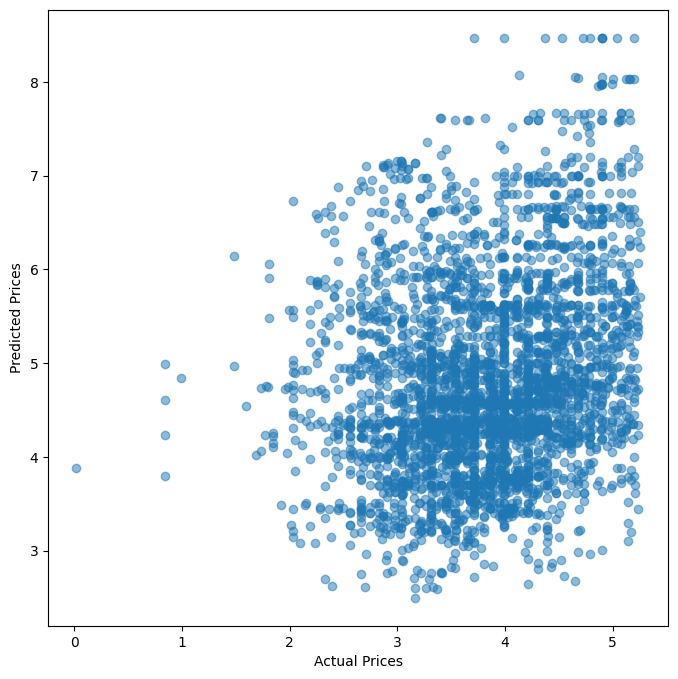

In [215]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test.asnumpy()Z, y_pred_test.asnumpy(), alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # This is the y=x line
plt.title('Actual vs Predicted Prices')
plt.show()


In [ ]:
# train_df.to_csv("./data/lot42_train.csv", index=False)


In [ ]:
# train_df.drop(["name", "price", "brand", "return_policy", "money_back", "seller_item_sold", "trending", "price_boxcox"], axis=1, inplace=True)
# train_df.to_csv("./data/lot42_trainfiltered.csv", index=False)

In [ ]:
X = df.drop(['price', 'price_log', 'price_boxcox'], axis=1)
y = df['price_log']

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# model = RandomForestRegressor(n_estimators = 100, random_state=42)
model = GradientBoostingRegressor(alpha=0.95, learning_rate=0.1, loss="huber", max_depth=9, max_features=0.8500000000000001, min_samples_leaf=10, min_samples_split=18, n_estimators=100, subsample=0.9000000000000001)
# model2 = XGBRegressor(n_estimators=100, random_state=42)
model2 = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8, random_state=42)
cv_scores1 = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores2 = cross_val_score(model2, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(cv_scores1, cv_scores2)

[-0.19115595 -0.18379917 -0.19151143 -0.19174013 -0.19759491] [-0.20684124 -0.19667603 -0.20105978 -0.20276344 -0.21463628]


In [ ]:
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from mlxtend.regressor import StackingCVRegressor
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Initialize the models
# rf = RandomForestRegressor(random_state=42)
# gb = GradientBoostingRegressor(random_state=42)
# xgboost = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)

# # Initialize Stacking Regressor
# stacking_regressor = StackingCVRegressor(
#     regressors=(rf, gb, xgboost), 
#     meta_regressor=xgb.XGBRegressor(objective ='reg:squarederror', random_state=42), 
#     cv=5, 
#     use_features_in_secondary=True
# )

# # Train the model
# stacking_regressor.fit(X_train.values, y_train.values)

# # Make predictions
# y_pred = stacking_regressor.predict(X_test.values)

# # Calculate the RMSE
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# print("RMSE: ", rmse)

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasRegressor

# # Function to create model for KerasClassifier
# def create_model():
#     model = Sequential()
#     model.add(Dense(10, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
#     model.add(Dense(1, kernel_initializer='normal'))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model

# # Initialize the model
# nn_model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# # Fit the model
# nn_model.fit(X_train, y_train)

# # Make predictions
# y_pred_nn = nn_model.predict(X_test)

# # Calculate RMSE
# rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
# print("RMSE Neural Network: ", rmse_nn)

In [ ]:
cv_xg_rmse = np.sqrt(-cv_scores2)
print(f'XGBOOST CV RMSE: {cv_xg_rmse.mean()} ± {cv_xg_rmse.std()}')

XGBOOST CV RMSE: 0.45205156117963063 ± 0.0066888818493344585


In [ ]:
cv_rf_rmse = np.sqrt(-cv_scores1)
print(f'XGBOOST CV RMSE: {cv_rf_rmse.mean()} ± {cv_rf_rmse.std()}')

XGBOOST CV RMSE: 0.4371899998076475 ± 0.005022250542475684


In [ ]:
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.95, loss='huber', max_depth=9,
                          max_features=0.8500000000000001, min_samples_leaf=10,
                          min_samples_split=18, subsample=0.9000000000000001)

In [ ]:
model2.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
y_pred = model.predict(X_test)
test_rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
print(f'Test RMSLE: {test_rmsle}')
print("RANDOM_FOREST_ACCURACY: ", (100 * (1 - test_rmsle)))

Test RMSLE: 0.09894926404684805
RANDOM_FOREST_ACCURACY:  90.1050735953152


In [ ]:
y_test_price = np.exp(y_test)
y_pred_price = np.exp(y_pred)
test_actual_rmsle = np.sqrt(mean_squared_log_error(y_test_price, y_pred_price))
print(f'Test ACTUAL RMSLE: {test_actual_rmsle}')
print("RANDOM_FOREST_ACCURACY: ", (100 * (1 - test_actual_rmsle)))

Test ACTUAL RMSLE: 0.41063234665947934
RANDOM_FOREST_ACCURACY:  58.93676533405207


In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV


# # Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
# }


# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# grid_search.best_params_, grid_search.best_score_

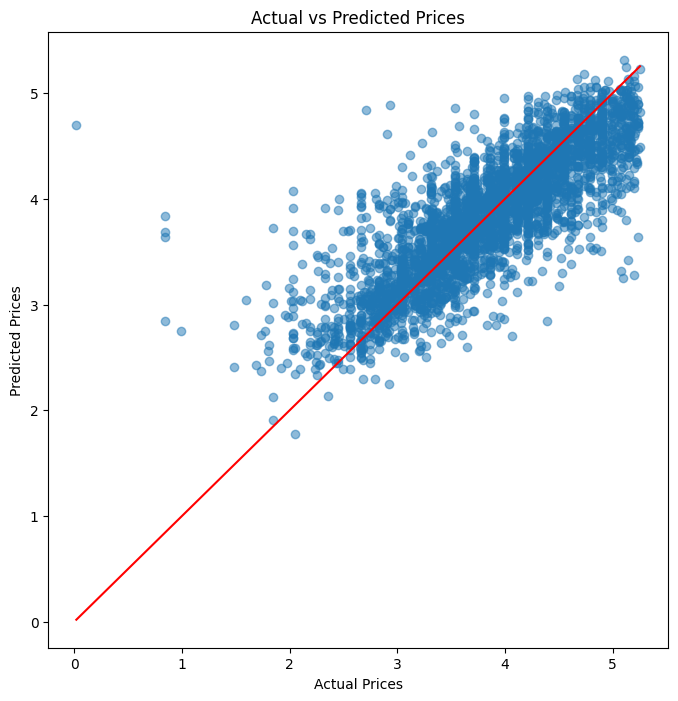

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # This is the y=x line
plt.title('Actual vs Predicted Prices')
plt.show()

In [ ]:
y_pred = model2.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {test_rmse}')
print("XGBOOST_ACCURACY: ", (100 * (1 - test_rmse)))

Test RMSE: 0.447464344095693
XGBOOST_ACCURACY:  55.253565590430696


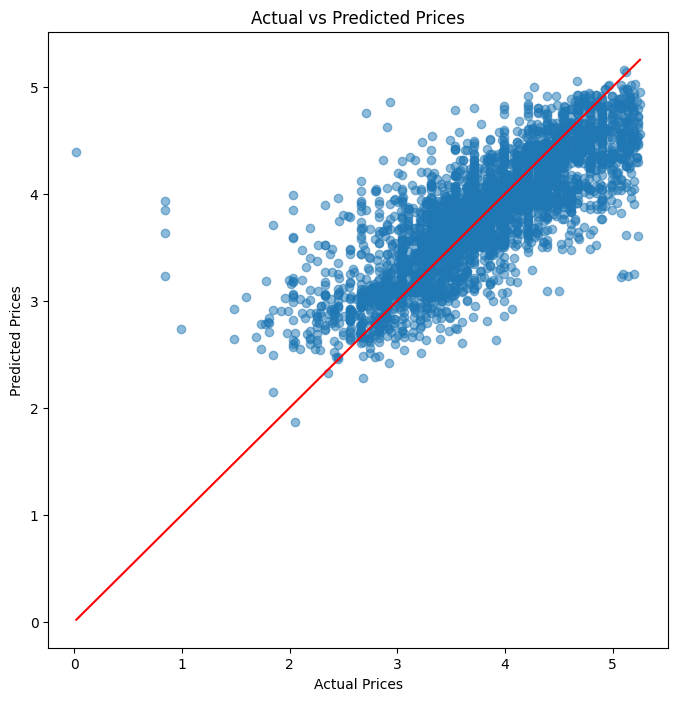

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # This is the y=x line
plt.title('Actual vs Predicted Prices')
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

m = LinearRegression()
m.fit(X_train, y_train)
y_pred = m.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("LIN_ACCURACY: ", (100 * (1 - rmse)))

print("Test RMSE:", rmse)


LIN_ACCURACY:  43.35625379256792
Test RMSE: 0.5664374620743208


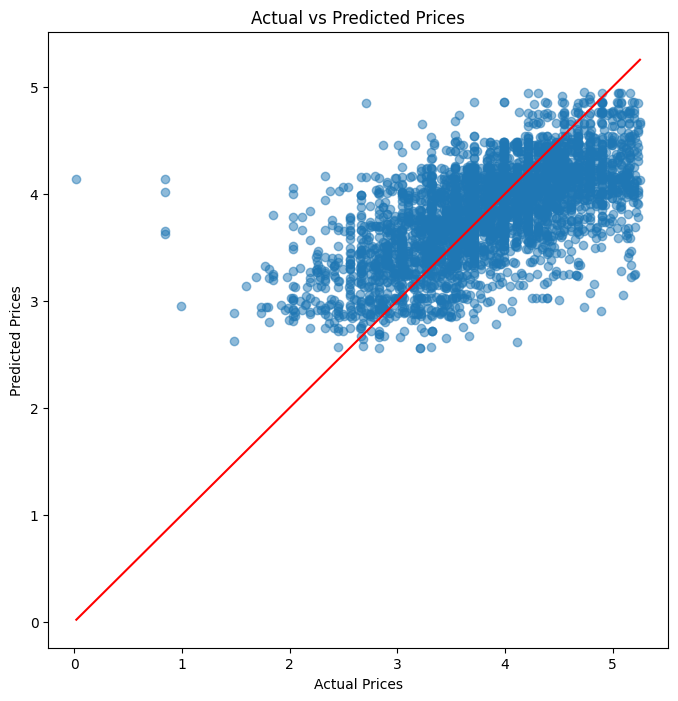

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # This is the y=x line
plt.title('Actual vs Predicted Prices')
plt.show()